In [1]:
import sys
import os
import matplotlib
import matplotlib.pyplot as plt

from itertools import zip_longest

from mrlattice.lattice.validate import *
from mrlattice.plotting import *
from mrlattice.lattice.generate import *

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.1.5"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>
<class '__main__.SuperimposeLatticeArrayPlotWidget'>


In [4]:
%load_ext jupyter_spaces

In [5]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Summary

We consolidate all previously presented validation tests into the test suite and complete it with an additional test for homogeneous lattices. We demonstrate how to use the test suite. Lastly, we evaluate the execution time of preconfigured validation suites with regard to automated unit tests.


# Consolidated Validation

To conclude our efforts for creating a validation suite for lattice arrays we now combine all the tests we presented in the previous notebooks into our `NewValidateLattice` class. We're not just adding the validation functions as methods (more on that later), but we're also changing how this class works. First we extend the constuctor and add the `sorted_props` and `increments` parameter explained in 0.1.5-01. We also register a new private variable `__suite_passed` that records *pass* or *failure* for each execution of the test suite inside the `launch_property_loops` loops. We modify that function as well. We change the iterator for all time slices to `time_slice_iterable`, which returns a tuple of time slices. Right now the first element starts at the first slice and the second at the second time slice and both step through the whole lattice. By using the special `zip_longest` function from itertools, it is possible to force this iteration to extend to all time slices for the first value of the tuple. The second value just repeats the last time slice for the last iteration. With this general setup we allow for test functions that require more time slices per test, which we can easily achieved by modifying `time_slice_iterable`.  
We add `__lattice_prop_start_vals` as a backup of the state the lattice array was before starting the tests. This makes it possible to supply a preconfigured lattice to the constructor of `NewValidateLattice` and start the property loops with the current values from the lattice array. To make this work we also change how we reset the properties' values before entering each nested loop. By exploiting the methods of the properties and lattice array we can reset the properties' values to the value that is closest to the saved starting values. In general these will differ, because properties depend on each others values.  
We also changed the call stack for executing the test suite. We wrapped `launch_property_loops` inside `__call__` and instead use the `__call__` method of the superclass inside `launch_property_loops`. This gives us the desired usage of just calling the instances for executing the whole suite.  
In summary, this means that we've changed how validation tests work conceptually. Now each test performs its validation on the level of time slices and the loop through the lattice is taken care of in `launch_property_loops`. This should come not only with a huge performance boost for extensive suites, but also simplify the test functions.

For this to be possible we altered the signatures of the validation test functions. As a template we added `the test_template_func`. The signature now consists of the positional arguments for the lattice array and the current number for the time step. Then follows a number of time slices. Right now the maximum number possible (set by `time_slice_iterable`) is 2. It is important to use `*args` on every test function, even if it does require both time slices, because of future tests requireing more time slices. Function that don't use these additional time slices just discard the positional arguments collected in `*args`. The same is true for keyword arguments.  
These changes also come into play, that the `__call__` function of the `NewValidateLattice` instances passes on any positinal and unknown keyword arguments to test functions. This makes it possible to control specific tests, that have some additional parameters, right when executing the test suite. In this notebook there is not demonstration for this, however.

We also want to point out some features of python sets that are usefull when working with the predefined `*_TEST_CASES`. Sets provide operations like *union* and *difference* so that it becomes easy to combine the existing `*_TEST_CASES` to new ones and supply them to `NewValidateLattice` instances.

Note that we've added a unit test special for `HomogeneousLatticeArray` and also prepared a `HOMOGENEOUS_TEST_CASES`.

In [6]:
class NewValidateLattice(ValidateLattice):
    
    _TEST_CASES = set([
        "test_buffer_size",
        "test_finest_width",
        "test_coarse_steps",
        "test_borders_width",
        "test_spatial_width",
        "test_zero_width",
        "test_neighbor_merge",
        "test_spatial_neighbors",
        "test_temporal_neighbors",
        "test_double_cell_tips",
        "test_diagonal_borders",
        "test_homogeneous",
    ])
    LATTICEARRAY_TEST_CASES = set([
        "test_buffer_size",
        "test_finest_width",
        "test_coarse_steps",
        "test_borders_width",
        "test_spatial_width",
        "test_zero_width",
        "test_neighbor_merge",
        "test_spatial_neighbors",
        "test_diagonal_borders",
    ])
    SUPERIMPOSE_TEST_CASES = set([
        "test_spatial_width",
        "test_zero_width",
        "test_neighbor_merge",
        "test_spatial_neighbors",
        "test_temporal_neighbors",
        "test_double_cell_tips",
    ])
    HOMOGENEOUS_TEST_CASES = set([
        "test_zero_width",
        "test_spatial_width",
        "test_homogeneous",
    ])
    
    def __init__(self, lattice, preset=None, sorted_props=None, increments=None, **funcs):
        super().__init__(lattice, preset, **funcs)
        self.__suite_passed = list()
        self.sorted_props = sorted_props if sorted_props else list()
        self.increments = increments if increments else [1] * len(sorted_props)
    
    def __call__(self, *args, stdout=open(os.devnull, 'w'), stderr=sys.stderr, **kwargs):
        # save starting values of lattice properties
        self.__lattice_prop_start_vals = dict(
            (k, getattr(self.lattice, k).value) for k in self.lattice.PROPERTY_DESCRIPTIONS)
        self.__suite_passed = list()
        # wrap recursive loops
        self.launch_property_loops(*args, stdout=stdout, stderr=stderr, **kwargs)
        print("\n" + "="*70 + f"\nTest suite called {len(self.__suite_passed)} times."
                f"\n{self.__suite_passed.count(True)} calls passed!",
                f"\n{self.__suite_passed.count(False)} calls failed!",
                file=stdout)
        # restore starting lattice, mind order
        for p in self.sorted_props:
            getattr(self.lattice, p).value = self.__lattice_prop_start_vals[p]
        
        return not bool(self.__suite_passed.count(False))
    
    def time_slice_iterable(self):
        """Return iterable for looping over time slices in `launch_property_loops`."""
        # use itertools zip to always cover all time slices
        return zip_longest(
            self.lattice.array,
            self.lattice.array[1:],
            fillvalue=self.lattice.array[-1])
    
    def launch_property_loops(self, *args, idx=0, stdout=open(os.devnull, 'w'), **kwargs):
        """Run nested prop change loops and validate each time.
        
        Depends on `self.sorted_props` for the lattice array properties
        to loop over and increment. Depends on `self.increments` for
        the number of times each property will be incremented.
        
        Args:
            idx:
                Start index for picking properties from `self.sorted_props`
                and nesting loops for each. Defaults to: 0.
            stdout:
                File like object to redirect stdout. Defaults to: Null.
        """
        for step in range(self.increments[idx]):
            # for the innermost loop
            if len(self.sorted_props[idx:]) == 1:
                self.lattice.generate_array()
                print("\n\n", self.lattice, file=stdout)
                # call test suite
                for step,timeslices in enumerate(self.time_slice_iterable()):
                    print(f"\nTime step {step}", file=stdout)
                    self.__suite_passed.append(
                        super().__call__(step, *timeslices, *args, stdout=stdout, **kwargs))
                # increment current prop
                getattr(self.lattice, self.sorted_props[idx]).increment()
                
            else:
                # reset value of next nesting's prop
                next_prop = getattr(self.lattice, self.sorted_props[idx+1])
                next_prop._value = self.__lattice_prop_start_vals[self.sorted_props[idx+1]]
                next_prop._check_bounds_and_update()
                self.lattice.update_properties()
                # recursive call
                self.launch_property_loops(*args, idx=idx+1, stdout=stdout, **kwargs)
                # increment current prop
                getattr(self.lattice, self.sorted_props[idx]).increment()
    
    @staticmethod
    def test_template_func(lattice, t, ts1, ts2, *args, key=True, **kwargs):
        """Template for lattice validation functions.
        
        Args:
            lattice: `LatticeArray` instance to test.
            t: Index of the current time slice.
            ts1: Time slice for index `t`.
            ts2: Time slice for index `t+1`.
            key: Some keyword arguments.
        """
        # do something with `ts1`, `ts2`
        # use `key`
        # *args could contain more time slices, not needed here
        # **kwargs could contain other args, not needed here
    
    @staticmethod
    def test_buffer_size_func(lattice, t, ts, *args, **kwargs):
        """Test the spatial width of the buffer(=coarsest) region."""
        buffer_res = 2**lattice.coarse_steps.value
        # filter time slice for correct coarsest region
        buffer = list(filter(lambda reg: reg[1] == buffer_res, ts))
        if not buffer:
            raise ValidationError(
                f"No region with resolution of buffer ({buffer_res}) "
                f"found in slice {t}:\n{ts}",
                "test_buffer_size")
        
        # test buffer spatial width
        for buffer_region in buffer:
            if buffer_region[-1] < lattice.buffer.value:
                raise ValidationError(
                    f"Spatial width of buffer for slice {t} is incorrect:\n"
                    f"{buffer_region} is not >= {lattice.buffer.value}",
                    "test_buffer_size")
    
    @staticmethod
    def test_finest_width_func(lattice, t, ts, *args, **kwargs):
        """Test the spatial width of the finest region."""

        # filter time slice for correct finest region
        finest = list(filter(lambda reg: reg[1] == 1, ts))
        if not finest:
            raise ValidationError(
                f"No region with resolution of finest ({1}) "
                f"found in slice {t}:\n{ts}",
                "test_finest_width")

        # test finest region's spatial width
        for finest_region in finest:
            if finest_region[-1] < lattice.finest_width.value:
                raise ValidationError(
                    f"Spatial width of finest region for slice {t} is incorrect:\n"
                    f"{finest_region} is not >= {lattice.finest_width.value}",
                    "test_finest_width")
            
    @staticmethod
    def test_coarse_steps_func(lattice, t, ts, *args, **kwargs):
        """Test number of coarse borders."""
    
        # compare with coarse_steps property
        if (reg_num := len(ts)-1) != lattice.coarse_steps.value:
            raise ValidationError(
                f"The number of region borders for slice {t} is incorrect:\n"
                f"{reg_num} is not {lattice.coarse_steps.value}",
                "test_coarse_steps")
    
    @staticmethod
    def test_borders_width_func(lattice, t, ts, *args, **kwargs):
        """Test coarsening regions' spatial width"""
    
        # counting from the left (small spatial coordinate)
        # skipping buffer and finest regions
        for ri, r in enumerate(ts[1:-1], 1):
            if lattice.scheme.name == lattice.scheme.FIXED_WIDTH_SCHEME:
                # asymmetric intervall
                if -r[1] >= (r[-1]*r[1] - lattice.borders_width.value) > r[1]:
                    raise ValidationError(
                        f"The width of the coarsening region number {ri} "
                        f"does not match requested width of {lattice.borders_width.value} "
                        f"at time slice {t}.",
                        "test_borders_width")    
            elif lattice.scheme.name == lattice.scheme.FIXED_NUMBER_SCHEME:
                if r[-1] - lattice.borders_width.value not in [0, 1]:
                    raise ValidationError(
                        f"The number of cells for coarsening region number {ri} "
                        f"does not match requested number of {lattice.borders_width.value} "
                        f"at time slice {t}.",
                        "test_borders_width")
            else:
                raise ValidationError(
                    f"No test available for lattice scheme: {lattice.scheme.name}",
                    "test_borders_width")
    
    @staticmethod
    def test_homogeneous_func(lattice, t, ts, *args, **kwargs):
        """Test if all cells are same resolution."""
        # this test only works for homogeneous lattices
        
        reg = lattice.array[0][0]
        if len(ts) != 1:
            raise ValidationError(
                "Homogeneous lattice contains more than one region in"
                f"time slice {t}:\n{ts}",
                "test_homogeneous")
        if reg[-1] != ts[0][-1]:
            raise ValidationError(
                f"Homogeneous lattice array changes resolution on time slice {t}\n"
                f"from {reg[-1]} to {ts[0][-1]}",
                "test_homogeneous")
        
    @staticmethod
    def test_spatial_width_func(lattice, t, ts, *args, **kwargs):
        """Test if all time slices have same spatial width."""
    
        # based on first time slice
        test_width = sum(r[1] * r[-1] for r in lattice.array[0])
        cur_width = sum(area[1] * area[-1] for area in ts)
        
        if cur_width != test_width:
            raise ValidationError(
                f"Spatial width of time slice {t} differs from previous.",
                "test_spatial_width")
            
    @staticmethod
    def test_zero_width_func(lattice, t, ts, *args, **kwargs):
        """Test for zero width regions."""
    
        zero = list(filter(lambda r: r[-1]==0, ts))
        if zero:
            raise ValidationError(
                f"Time slice {t} contains regions with zero width: {zero}.",
                "test_zero_width")
            
    @staticmethod
    def test_neighbor_merge_func(lattice, t, ts, *args, **kwargs):
        """Test if neighboring regions have same resolution."""
        
        for r1, r2 in zip(ts[:-1], ts[1:]):
            if r1[1] == r2[1]:
                raise ValidationError(
                    f"Timse slice {t} contains two neighboring regions with "
                    f"the same resolution {r[1]}. They should me merged.",
                    "test_neighbor_merge")
                
    @staticmethod
    def test_spatial_neighbors_func(lattice, t, ts, *args, **kwargs):
        """Test if spatial neighbors' resolution only differ by 2x."""
        
        for r1, r2 in zip(ts[:-1], ts[1:]):
            if r1[1]/r2[1] not in [1/2, 1, 2]:
                raise ValidationError(
                    f"Time slice {t} contains two neighboring regions where "
                    "the resolutions differ by more than a factor of 2:\n"
                    f"reg 1: {r1}\treg 2: {r2}",
                    "test_spatial_neighbors")
                
    @staticmethod
    def test_diagonal_borders_func(lattice, t, ts1, ts2, *args, **kwargs):
        """Test diagonal borders staircase edge."""
        # this test is designed for the base LatticeArray
        # and requires the same number of regions per time slice
        # other derived types may not give correct results
    
        diff = [ r1[-1] - r2[-1] for r1, r2 in zip(ts1, ts2) ]
        
        for i,d in enumerate(diff):
            # finest region is always 2x
            dc = 2/min(2, ts1[i][1])
            if d not in [-dc, 0, dc]:
                raise ValidationError(
                    f"Time slices {t} and {t+1} have discontinuous diagonal borders "
                    f"for regions:\n{ts1[i]} and {ts2[i]}",
                    "test_diagonal_borders")
                
    @staticmethod
    def test_temporal_neighbors_func(lattice, t, ts1, ts2, *args, **kwargs):
        """Test if temporal neighbors' resolution only differ by 2x."""
        
        # get print representation of time slices
        ts1 = generate_print_lattice([ts1])
        ts2 = generate_print_lattice([ts2])
        # error flag
        msg = str()
        
        # test direct temporal neighbor
        res = np.isin((ts1 / ts2), [1/2, 1, 2])
        res = np.where(res, 0, 1).nonzero()[0]
        if res.size:
            msg+=f"{res} and {res}\n"
           
        # test left diag temporal neighbor
        res = np.isin((ts1[1:]/ts2[:-1] ), [1/2, 1, 2])
        res = np.where(res, 0, 1).nonzero()[0]
        if res.size:
            msg+=f"{res+1} and {res}\n"

        # test right diag temporal neighbor
        res = np.isin((ts1[:-1]/ts2[1:] ), [1/2, 1, 2])
        res = np.where(res, 0, 1).nonzero()[0]
        if res.size:
            msg+=f"{res} and {res+1}\n"
    
        if msg:
            raise ValidationError(
                f"Time slices {t} and {t+1} have temproal neighbors that differ "
                f"more than 2x in resolution at positions [finest units]:\n{msg}",
                "test_temporal_neighbors")
            
    @staticmethod
    def test_double_cell_tips_func(lattice, t, ts1, ts2, *args, **kwargs):
        """Test if cusps only have double cell tips in spatial direction."""
        # this test is designed for SuperimposeLatticeArray
        # and tests cusps with double cell tips
        # other lattices without cups may not give correct results
    
        r_diff = len(ts1) - len(ts2)
        if r_diff == 2:
            time_slice = ts1
        elif r_diff == -2:
            time_slice = ts2
        elif r_diff == 0:
            return
        else:
            raise ValidationError(
                f"The change in regions from time slice {t} to {t+1} "
                "couldn't be identified as a cusp.",
                "test_double_cell_tips")
        
        faulty_reg_idx = len(time_slice)//2
        if time_slice[faulty_reg_idx][-1] != 2:
            raise ValidationError(
                f"Time slices {t} and {t+1} contain a cusp that "
                "has no double cell tip. Region:\n"
                f"{time_slice[faulty_reg_idx]} number {faulty_reg_idx}",
                "test_double_cell_tips")

## Example Execution

In [7]:
PROPS = {
    "scheme":"fixed_width",
    "coarse_steps":4,
    "borders_width":30,
    "buffer":3,
    "finest_width":7,
    "repeat":4,
}
fw_lattice = LatticeArray(**PROPS)
fw_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
fw_valid = NewValidateLattice(
    fw_lattice,
    preset=NewValidateLattice.LATTICEARRAY_TEST_CASES,
    sorted_props=prop_sort)

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

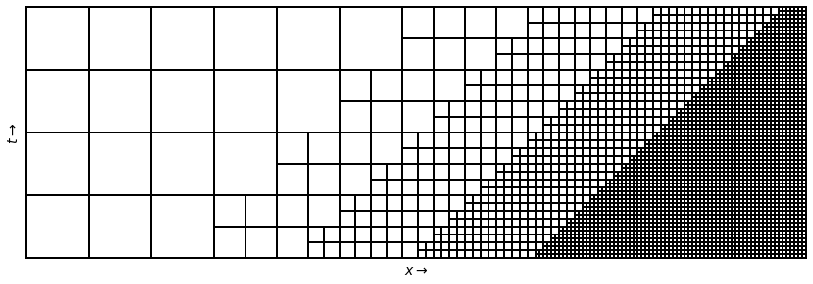

In [8]:
ww = LatticeArrayPlotWidget(lattice=fw_lattice)
ww.alpha_bg.value = True
ww._plot_button_on_click()
display(ww)

In [9]:
%%capture output
# superimposed lattice
fw_valid(stdout=sys.stdout)

In [10]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 64 times.
64 calls passed! 
0 calls failed!



In [11]:
PROPS = {
    "scheme":"fixed_width",
    "coarse_steps":4,
    "borders_width":30,
    "buffer":3,
    "finest_width":16,
    "repeat":9,
}
sup_lattice = SuperimposeLatticeArray(**PROPS)
sup_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
sup_valid = NewValidateLattice(
    sup_lattice,
    preset=NewValidateLattice.SUPERIMPOSE_TEST_CASES,
#     preset=NewValidateLattice.SUPERIMPOSE_TEST_CASES | set(["test_diagonal_borders"]),
    sorted_props=prop_sort)

SuperimposeLatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number o…

Output()

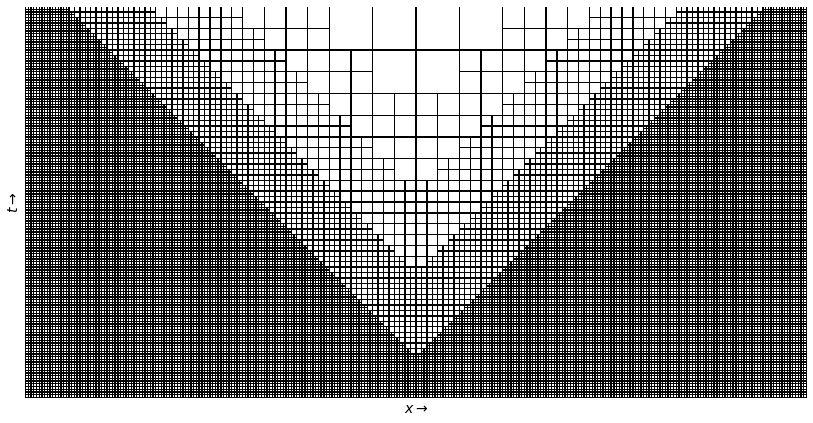

In [12]:
sup = SuperimposeLatticeArrayPlotWidget(lattice=sup_lattice)
sup.alpha_bg.value = True
sup._plot_button_on_click()
display(sup)

In [13]:
%%capture output
# superimposed lattice
sup_valid(stdout=sys.stdout)

In [14]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 144 times.
144 calls passed! 
0 calls failed!



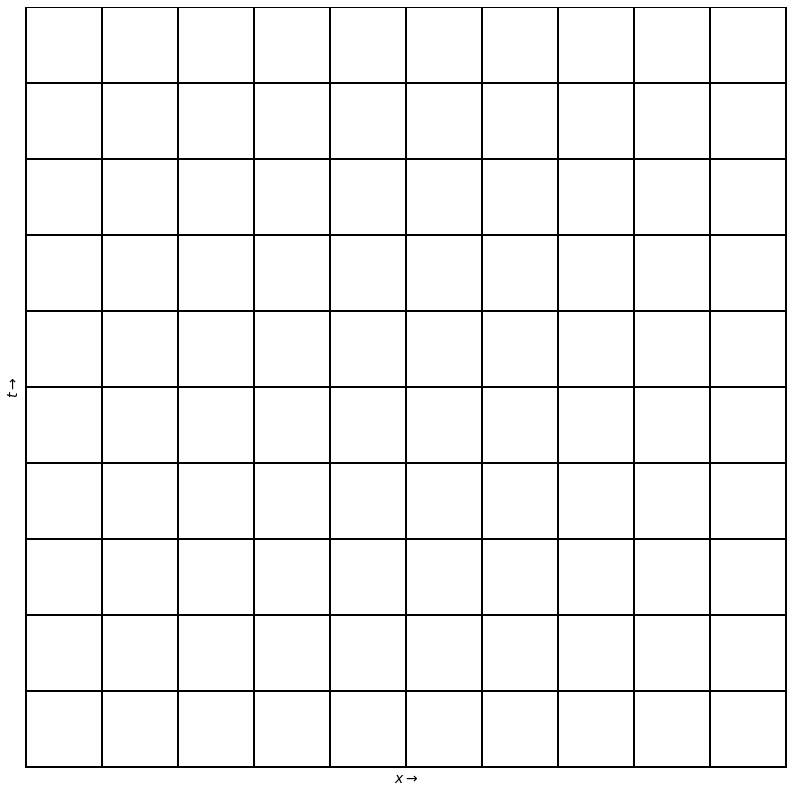

In [15]:
PROPS = {
    "coarse_steps":4,
    "buffer":10,
    "repeat":10,
}
hom_lattice = HomogeneousLatticeArray(**PROPS)
hom_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "repeat",
]
plot_mesh(generate_plot_lattice(hom_lattice.array), alpha_bg=True);

In [16]:
%%capture output
valid = NewValidateLattice(
    hom_lattice,
    preset=NewValidateLattice.HOMOGENEOUS_TEST_CASES,
    sorted_props=prop_sort)
valid(stdout=sys.stdout)

In [17]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 160 times.
160 calls passed! 
0 calls failed!



## Timing Full Suite Execution

We now want to time how long a full test suite with a desireable coverage of configurations takes. What we want to determine is, if including a thorough test suite in the automated unit tests is meaningful when considering the limited ressources available with the current testing servers.

### LatticeArray

We start with the simple `LatticeArray` type. We aim for a wide coverageof configurations, but as the lattice gets bigger, the tests will take longer. So we settle on a compromise, where we start with the simplest configuration with all values at minimum. Then we increment each of the 4 times. This ensures that changing the properties' values doesn't invalidate the lattice.  
Then we configure a second suite, where we start with a large lattice and just change the `coarse_steps` property in the loops. We chose this property, because it is the only one that changes the *shape* of the lattice array. All the others just scale it in some way.  
Of course, we have to test both schemes.

In [18]:
%%capture output
# minimal diagonal border test (fixed_width)
PROPS = {
    "scheme":"fixed_width",
}
lattice = LatticeArray(**PROPS)
lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
valid = NewValidateLattice(
    lattice,
    preset=NewValidateLattice.LATTICEARRAY_TEST_CASES,
    sorted_props=prop_sort,
    increments = [4]*len(prop_sort)
)

%timeit -r 3 -n 10 valid(stdout=sys.stdout)

In [19]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 19200 times.
19200 calls passed! 
0 calls failed!
536 ms +- 17.3 ms per loop (mean +- std. dev. of 3 runs, 10 loops each)



In [20]:
%%capture output
# minimal diagonal border test (fixed_number)
PROPS = {
    "scheme":"fixed_number",
}
lattice = LatticeArray(**PROPS)
lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
valid = NewValidateLattice(
    lattice,
    preset=NewValidateLattice.LATTICEARRAY_TEST_CASES,
    sorted_props=prop_sort,
    increments = [4]*len(prop_sort)
)

%timeit -r 3 -n 10 valid(stdout=sys.stdout)

In [21]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 19200 times.
19200 calls passed! 
0 calls failed!
545 ms +- 7.06 ms per loop (mean +- std. dev. of 3 runs, 10 loops each)



In [22]:
%%capture output
# full diagonal border test (fixed_width)
PROPS = {
    "scheme":"fixed_width",
    "coarse_steps":4,
    "borders_width":30,
    "buffer":5,
    "finest_width":30,
    "repeat":4,
}
lattice = LatticeArray(**PROPS)
lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
valid = NewValidateLattice(
    lattice,
    preset=NewValidateLattice.LATTICEARRAY_TEST_CASES,
    sorted_props=prop_sort,
    increments = [1, 6, 1, 1, 1]
)

%timeit -r 3 -n 10 valid(stdout=sys.stdout)

In [23]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 4032 times.
4032 calls passed! 
0 calls failed!
127 ms +- 3.92 ms per loop (mean +- std. dev. of 3 runs, 10 loops each)



In [24]:
%%capture output
# full diagonal border test (fixed_number)
PROPS = {
    "scheme":"fixed_number",
    "coarse_steps":4,
    "borders_width":6,
    "buffer":5,
    "finest_width":30,
    "repeat":4,
}
lattice = LatticeArray(**PROPS)
lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
valid = NewValidateLattice(
    lattice,
    preset=NewValidateLattice.LATTICEARRAY_TEST_CASES,
    sorted_props=prop_sort,
    increments = [1, 6, 1, 1, 1]
)

%timeit -r 3 -n 10 valid(stdout=sys.stdout)

In [25]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 4032 times.
4032 calls passed! 
0 calls failed!
132 ms +- 1.04 ms per loop (mean +- std. dev. of 3 runs, 10 loops each)



### SuperimposeLatticeArray

For the `SuperimposeLatticeArray` the situation is similar. However, we reduce the number of steps per property for the first suite to 3, which already takes longer than previously. For the second suite we decide to only change the `buffer` property. With the previous tests, we've already verified that changing `course_steps` keeps the lattice valid. Here, that property behaves the same. But the `buffer` property (together with `finest_width` and `repeat`) actually changes the shape now. For high values of `buffer` (and keeping others fixed) we insert a wedge into the lattice from later time slices (in the default output orientation). This wedge first separates the finest region and then splits the coarsening borders until the lattice consists of 3 distinct parts. The left and right third are the coarsening borders with the finest regions at the very margins. In the center the coarsest region extends from the first to the last time slice. So by testing `buffer` values we examine the validity of this change. Because it takes many increments to `buffer` to observe both extremes, we settle on 10 steps.

In [26]:
%%capture output
# minimal superimpose lattice test (fixed_width)
PROPS = {
    "scheme":"fixed_width"
}
sup_lattice = SuperimposeLatticeArray(**PROPS)
sup_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
sup_valid = NewValidateLattice(
    sup_lattice,
    preset=NewValidateLattice.SUPERIMPOSE_TEST_CASES,
    sorted_props=prop_sort,
    increments = [3]*len(prop_sort)
)
%timeit -r 3 -n 10 sup_valid(stdout=sys.stdout)

In [27]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 8694 times.
8694 calls passed! 
0 calls failed!
1.08 s +- 10.4 ms per loop (mean +- std. dev. of 3 runs, 10 loops each)



In [28]:
%%capture output
# minimal superimpose lattice test (fixed_number)
PROPS = {
    "scheme":"fixed_number"
}
sup_lattice = SuperimposeLatticeArray(**PROPS)
sup_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
sup_valid = NewValidateLattice(
    sup_lattice,
    preset=NewValidateLattice.SUPERIMPOSE_TEST_CASES,
    sorted_props=prop_sort,
    increments = [3]*len(prop_sort)
)
%timeit -r 3 -n 10 sup_valid(stdout=sys.stdout)

In [29]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 8694 times.
8694 calls passed! 
0 calls failed!
1.09 s +- 17.6 ms per loop (mean +- std. dev. of 3 runs, 10 loops each)



In [30]:
%%capture output
# full superimpose lattice test (fixed_width)
PROPS = {
    "scheme":"fixed_width",
    "coarse_steps":3,
    "borders_width":14,
    "buffer":4,
    "finest_width":8,
    "repeat":6,
}
sup_lattice = SuperimposeLatticeArray(**PROPS)
sup_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
sup_valid = NewValidateLattice(
    sup_lattice,
    preset=NewValidateLattice.SUPERIMPOSE_TEST_CASES,
    sorted_props=prop_sort,
    increments = [10, 1, 1, 1, 1]
)
%timeit -r 3 -n 10 sup_valid(stdout=sys.stdout)

In [31]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 520 times.
520 calls passed! 
0 calls failed!
66.6 ms +- 93.4 us per loop (mean +- std. dev. of 3 runs, 10 loops each)



In [32]:
%%capture output
# full superimpose lattice test (fixed_number)
PROPS = {
    "scheme":"fixed_number",
    "coarse_steps":3,
    "borders_width":4,
    "buffer":4,
    "finest_width":10,
    "repeat":6,
}
sup_lattice = SuperimposeLatticeArray(**PROPS)
sup_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
sup_valid = NewValidateLattice(
    sup_lattice,
    preset=NewValidateLattice.SUPERIMPOSE_TEST_CASES,
    sorted_props=prop_sort,
    increments = [10, 1, 1, 1, 1]
)
%timeit -r 3 -n 10 sup_valid(stdout=sys.stdout)

In [33]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 520 times.
520 calls passed! 
0 calls failed!
67.1 ms +- 940 us per loop (mean +- std. dev. of 3 runs, 10 loops each)



### HomogeneousLatticeArray

Lastly, we time the test suite for the `HomogeneousLatticeArray` tupe.

In [34]:
%%capture output
PROPS = {
    "coarse_steps":4,
    "buffer":10,
    "repeat":10,
}
hom_lattice = HomogeneousLatticeArray(**PROPS)
hom_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "repeat",
]
valid = NewValidateLattice(
    hom_lattice,
    preset=NewValidateLattice.HOMOGENEOUS_TEST_CASES,
    sorted_props=prop_sort,
    increments=[2]*3)
%timeit -r 3 -n 10 valid(stdout=sys.stdout)

In [35]:
# restrict number of lines in output
[ print(o) for o in output.stdout.split("\n\n")[-1:] ];

Test suite called 2016 times.
2016 calls passed! 
0 calls failed!
16.5 ms +- 147 us per loop (mean +- std. dev. of 3 runs, 10 loops each)

